### 1. 配置路径

In [1]:
import os
import sys
import torch

cur_path = os.getcwd()
root_path = os.path.split(cur_path)[0]
sys.path.append(root_path)
%cd $root_path

/sda1/tyz/SegmenTron-master


### 2. 加载配置

In [2]:
from segmentron.config import cfg

config_file = 'configs/ade20k_maskformer_swin_b.yaml'
cfg.update_from_file(config_file)
cfg.PHASE = 'test'
cfg.ROOT_PATH = root_path
cfg.TEST.TEST_MODEL_PATH = 'runs/checkpoints/MaskFormer_swin_b_224_ade20k_2024-05-27-12-03/best_model.pth'
cfg.TEST.BATCH_SIZE = 8
cfg.check_and_freeze()

### 3. 加载模型

In [3]:
from segmentron.models import MODEL_REGISTRY

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_name = cfg.MODEL.MODEL_NAME
model = MODEL_REGISTRY.get(model_name)().to(device)
if cfg.TEST.TEST_MODEL_PATH:
    msg = model.load_state_dict(torch.load(cfg.TEST.TEST_MODEL_PATH, map_location=device), strict=False)
    print(msg)
model.eval()

/home/julian-tang/miniconda3/envs/segmentron/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>


MaskFormer(
  (encoder): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=128, out_features=512,

### 3. 读取图像

In [4]:
from PIL import Image
from torchvision import transforms
import torch.utils.data as data
from segmentron.data.dataloader import get_segmentation_dataset
from segmentron.utils.distributed import *
import matplotlib.pyplot as plt
%matplotlib inline

# image transform
input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cfg.DATASET.MEAN, cfg.DATASET.STD),
])
# dataset and dataloader
data_kwargs = {'transform': input_transform, 'base_size': cfg.TRAIN.BASE_SIZE,
               'crop_size': cfg.TRAIN.CROP_SIZE}

train_dataset = get_segmentation_dataset(cfg.DATASET.NAME, split='train', mode='val', **data_kwargs)
train_sampler = make_data_sampler(train_dataset, shuffle=True, distributed=False)
train_batch_sampler = make_batch_data_sampler(train_sampler, cfg.TEST.BATCH_SIZE, drop_last=False)
train_loader = data.DataLoader(dataset=train_dataset,
                               batch_sampler=train_batch_sampler,
                               num_workers=cfg.DATASET.WORKERS,
                               pin_memory=True)

### 5. 推理

In [5]:
batch_inputs = next(iter(train_loader))
images, targets, _ = batch_inputs
preds = model(images.to(device))["inference_results"]
masks = preds.argmax(1).cpu().data.numpy()

### 6. 可视化

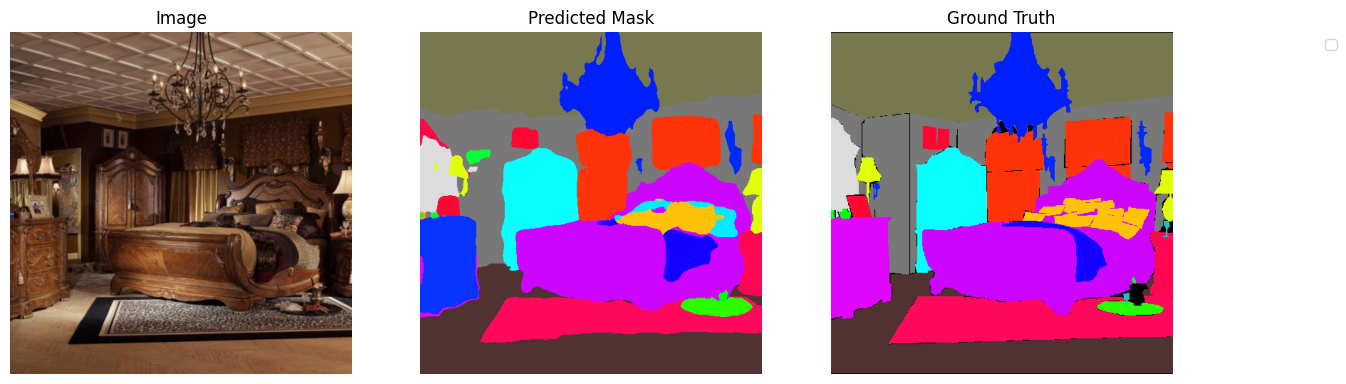

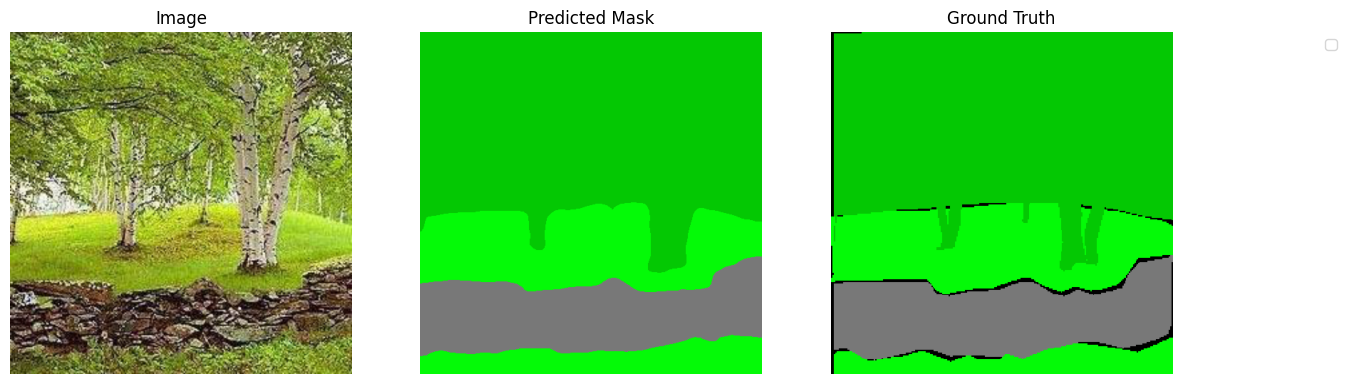

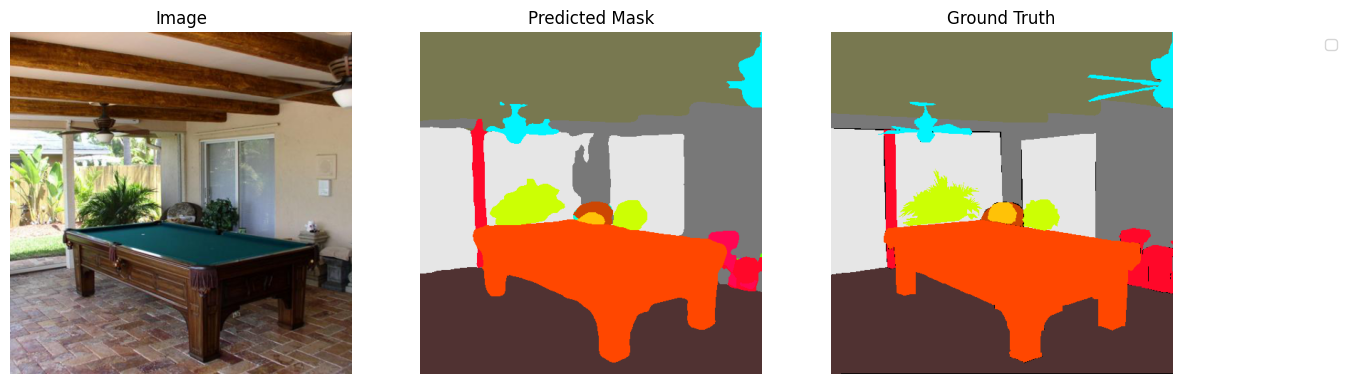

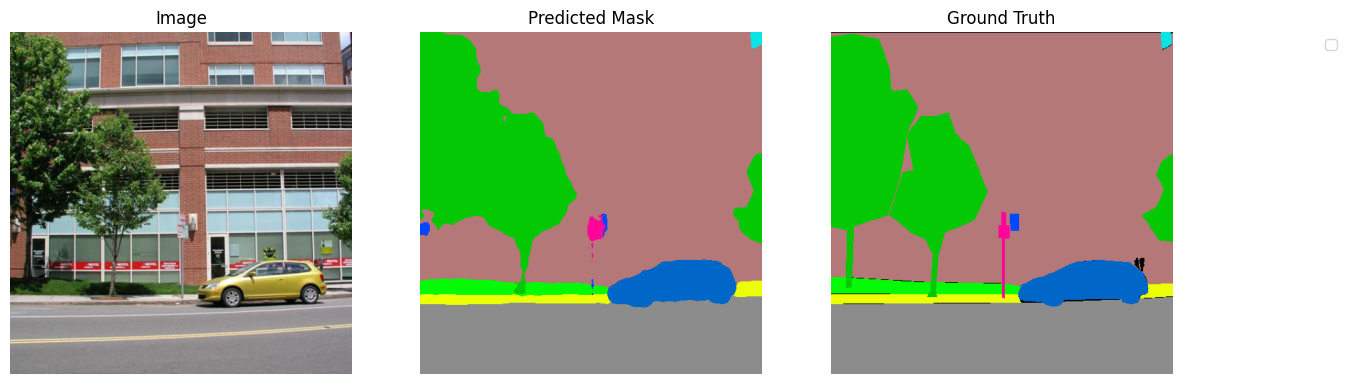

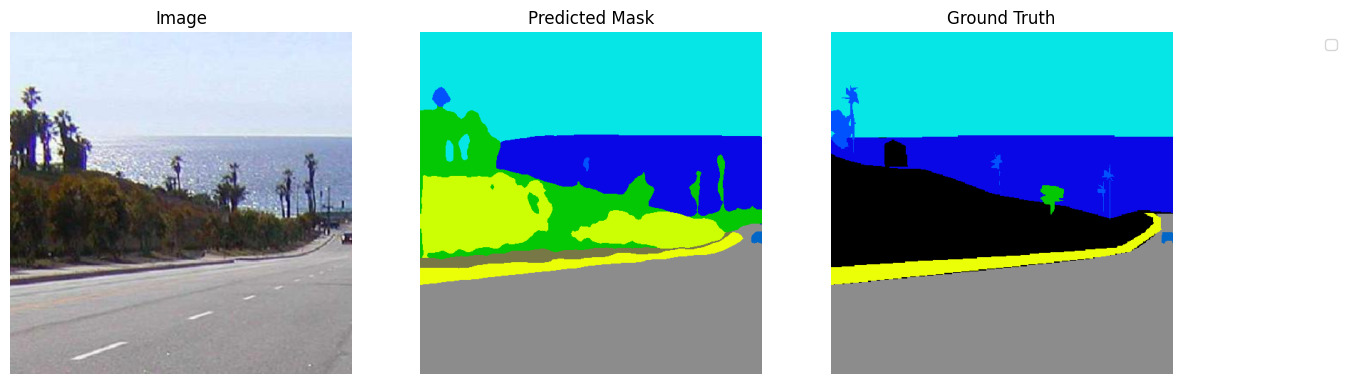

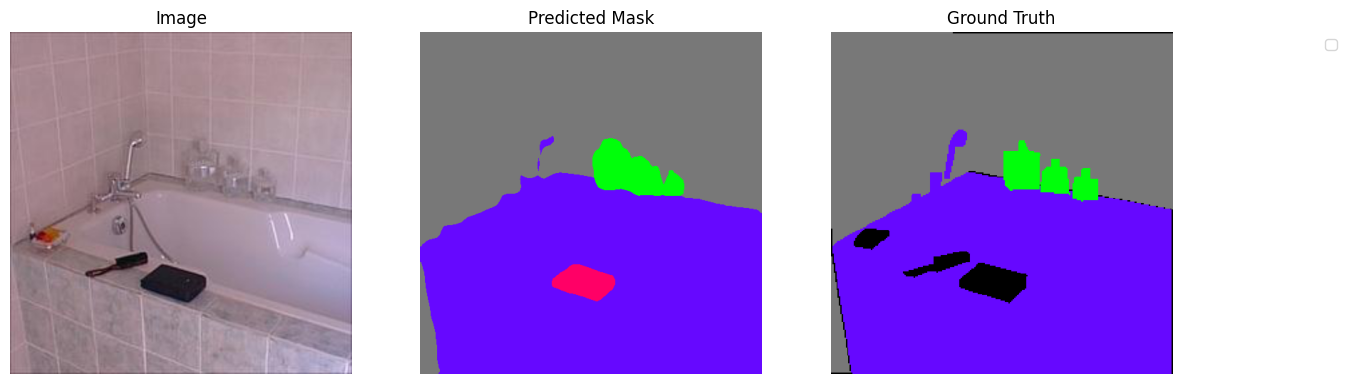

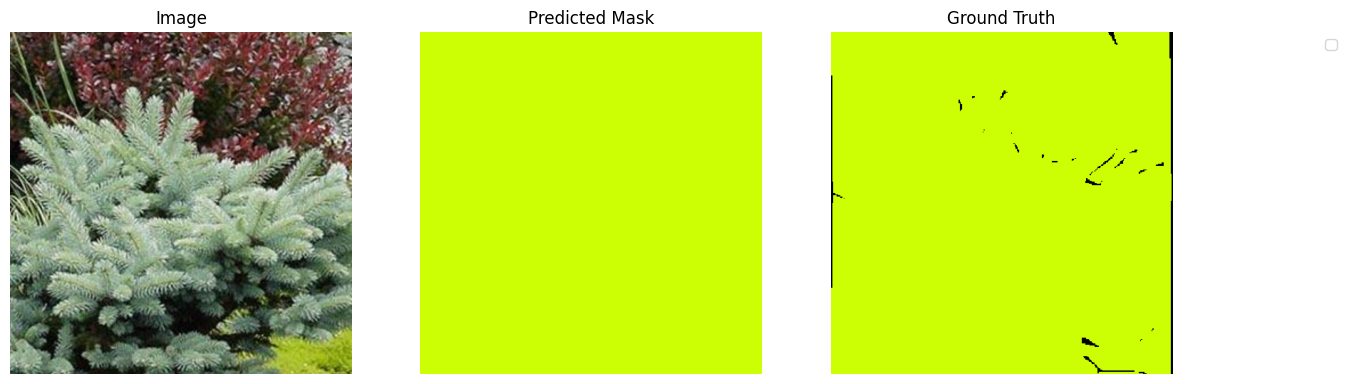

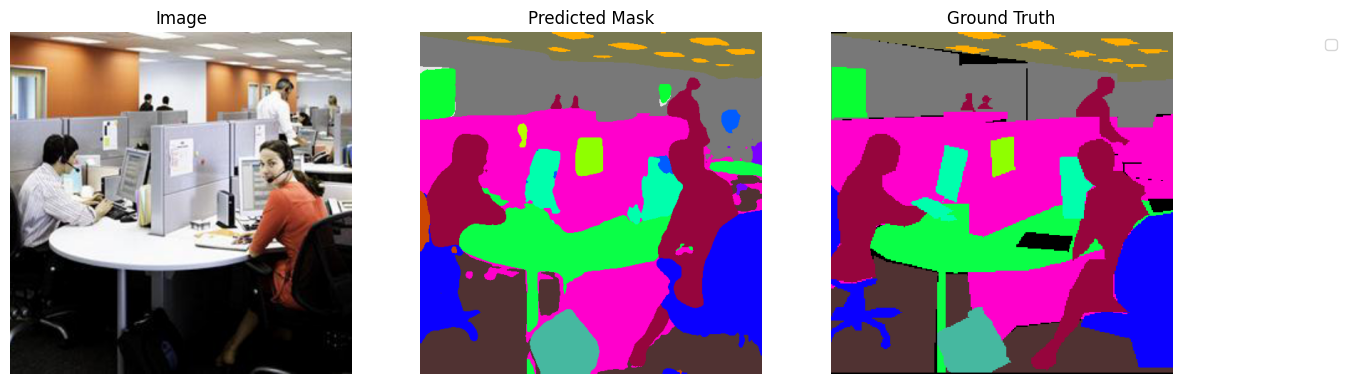

In [6]:
from segmentron.utils import show_image_with_mask_gt_legend

for i in range(cfg.TEST.BATCH_SIZE):
    show_image_with_mask_gt_legend(images[i], masks[i], targets[i], cfg.DATASET.NAME, cfg.DATASET.MEAN, cfg.DATASET.STD, train_dataset.classes)